#　量子鍵配送プロトコル BB84について理解を深めてみる
---
### 1. QKDについて
最近、色々なところで実証実験が進められている量子鍵配送=「Quantum Key Distribution(QKD)」は、信頼された2者に対して、「暗号鍵」を供給する方式の１つです。<br>
量子鍵配送では、量子力学の原理を利用して、盗聴が検知できる通信チャンネルを形成し、その上で暗号鍵の情報を送受信します。　　<br>
一度、２者間で安全な暗号鍵が共有できれば、ワンタイムパッド方式と呼ばれる暗号方式を用いることにより、インターネットなどの通信回線を使って絶対的に安全な暗号通信が可能となります。

>ワンタイムパッド (One Time Pad, OTP)  
>通信量と同じ長さの乱数列を使用し暗号化、1回使った乱数表は捨てる。   
>乱数の秘匿だけで暗号強度を保つことができるという利点がある。<br>
>※量子力学の性質を利用して、真性乱数を生成する量子乱数生成デバイスも登場しているが、それはまた別の機会に。

### 2. BB84について
今回のメインテーマ、具体的な量子鍵配送のプロトコルであるBB84について確認します。<br>
BB84は、1984年にBennetとBrassardという人が提案したプロトコルで、量子鍵配送の最もポピュラーな方式です。<br>


<div align="center">
    <img src="img/qkd_alice-bob-eve.png" width="500">
    <br>
    <em>量子鍵配送のイメージ</em>
</div>

上に載せた画像のように、送信したい暗号鍵に相当するビット列から１ビットずつ量子に情報をのせて、アリスからボブへ渡しています。<br>
その量子をイブが盗み見ようとしますが、アリスとボブはイブが盗み見ようとしたことを検知することができるので、そのような暗号鍵は破棄して、再度、生成した暗号鍵の配送を試みます。<br>
これによって、安全に暗号鍵を２者間で共有することができます。<br>
ここから具体的に、どのように暗号鍵を共有するのか。また、盗聴を検知することができるのか。順に見ていきます。<br>

>メモ<br>
>以前、量子鍵配送による通信網の構築を研究されている方へ、盗聴によって、通信を妨害することができてしまうのではないか？と質問したところ<br>
>「そうならないために、現在のインターネットのように多様な経路で送信できる通信網を構築することが重要。」<br>
>とのことでした。


#### 2.1 アリスからボブへの暗号鍵の送信
まずは、アリス側の準備として、適当な桁数のビット列を２つ作成します。

$$
\begin{align}
a&=0100010111 \\
b&=1110101001
\end{align}
$$

この「a」が暗号鍵のベース、「b」が通信結果の突き合わせを行うための情報とします。<br>
（後述しますが、「a」のすべてが暗号鍵となる訳ではありません。）<br>
<br>
この２つのビット列を縦に並べて、値のペアに対して、１つの量子状態$\ket{\Psi}_{a{_i}b{_i}}$を割り当てます。<br>
$$
\begin{align}
\ket{\Psi}_{00}&=\ket{0} \\
\ket{\Psi}_{10}&=\ket{1} \\
\ket{\Psi}_{01}&=\frac{1}{\sqrt{2}}(\ket{0} + \ket{1}) = \ket{+} \\
\ket{\Psi}_{11}&=\frac{1}{\sqrt{2}}(\ket{0} - \ket{1}) = \ket{-}
\end{align}
$$
それぞれのビット列のインデックスは、右端から数えることにして、上記の規則を当てはめると<br>
|インデックス|9|8|7|6|5|4|3|2|1|0|
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|a        |0|1|0|0|0|1|0|1|1|1|
|b        |1|1|1|0|1|0|1|0|0|1|
|$\ket{\Psi}$|$\ket{+}$|$\ket{-}$|$\ket{+}$|0|$\ket{+}$|1|$\ket{+}$|1|1|$\ket{-}$|

このようになります。<br>
この量子状態$\ket{\Psi}_{a{_i}b{_i}}$の中に$\ket{+}$と$\ket{-}$が混ざっていることで外部からの盗聴を困難にしています。<br>
<br>
アリスからボブへこのように定義・作成した量子状態$\ket{\Psi}$を送信します。

>メモ： 量子状態と量子の重ね合わせについて<br>
>通常のコンピュータが扱う情報の基本単位の（古典）ビットは、「０」 or 「１」のどちらかのみ。<br>
>それに対して、量子コンピュータが扱う量子ビットは、「０」 「１」に加えて、これらの状態の重ね合わせ状態をとることができます。<br>
>重ね合わせ状態の量子ビットは、基底に対する測定を行うことで、離散的な状態へジャンプします。（Z基底=計算基底で測定する場合、「０」 or 「１」）<br>
><br>
>量子ビットの状態は、ブロッホ球と呼ばれる可視化手法を用いて表すことができるので、ブロッホ球で上記の４状態を表してみます。

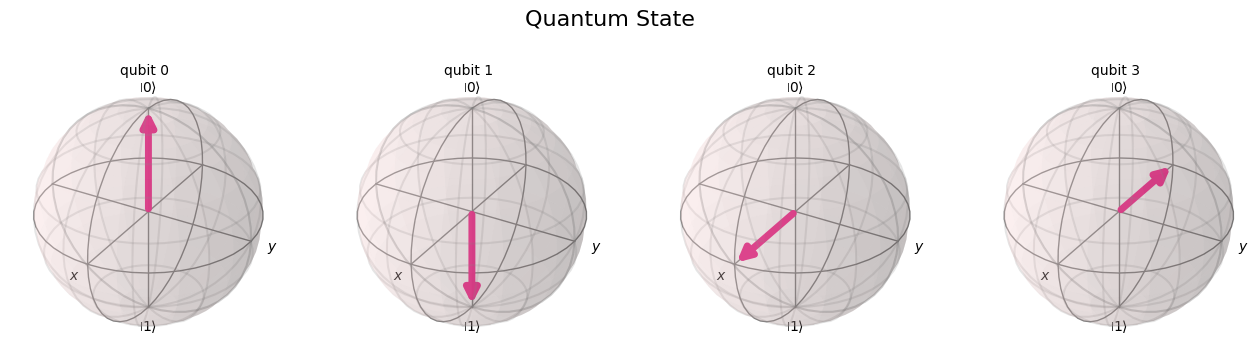

In [1]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

circuit = QuantumCircuit(4) # 量子ビットは０で初期化されるので、量子ゲートをかけて、それ以外の状態を作成
circuit.x(1)  # Xゲート（ビット反転）
circuit.h(2)  # Hゲート（アダマールゲート）
circuit.x(3)
circuit.h(3)  # |- >はXゲート　-> Hゲートで作成

state = Statevector.from_instruction(circuit)

plot_bloch_multivector(state, title="Quantum State")

>ついでに、↑で量子ビットに対して、ゲートをかけた操作を行った量子回路を表示すると↓な感じ。

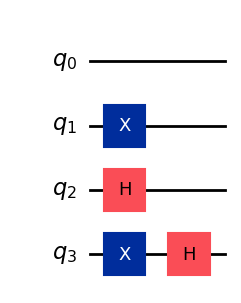

In [2]:
circuit.draw('mpl')

#### 2.2 ボブによる測定
通信の準備として、ボブもランダムな10桁のビット列を作成します。ここでは例として、

$$
\begin{align}
b'&=1110110101
\end{align}
$$

とします。<br>
ボブは作成したパラメータ b'に基づいて、アリスから送られてきた量子状態を１桁ずつ（実際は、送られてきた量子ビットごと）測定していきます。<br>
その際に、測定する基底は、

$$
\begin{align}
b'=0 \rightarrow Z基底、b'=1 \rightarrow X基底
\end{align}
$$
とし、得られた測定値をcとすると以下のような結果が得られたとします。

|インデックス|9|8|7|6|5|4|3|2|1|0|
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|$\ket{\Psi}$|$\ket{+}$|$\ket{-}$|$\ket{+}$|0|$\ket{+}$|1|$\ket{+}$|1|1|$\ket{-}$|
|b'       |1|1|1|0|1|1|0|1|0|1|
|c        |0|1|0|0|0|0|1|0|1|1|

>メモ： Z基底、X基底による測定<br>
>Z基底での測定では、$\ket{0}$,$\ket{1}$は、それぞれ「0」、「1」として測定されますが、
>$\ket{+}$、$\ket{-}$は、５０％の確率で「0」、「1」のどちらかとして測定されます。
>また、<br>
>X基底での測定では、$\ket{+}$,$\ket{-}$は、それぞれ「0」、「1」として測定されますが、
>$\ket{0}$、$\ket{1}$は、５０％の確率で「0」、「1」のどちらかとして測定されます。

#### 2.3 鍵の共有
ボブが測定を終わった段階で、アリスとボブはお互いのパラメータb, b'を突き合わせます。この作業は誰に見られても問題ありません。

$$
\begin{align}
b&=1110101001 \\
b'&=1110110101
\end{align}
$$

お互いに、1桁ずつ一致・不一致を確認し、b, b'の不一致のインデックスの部分をa, cから捨てることにします。<br>

|インデックス|9|8|7|6|5|4|3|2|1|0|
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|b        |1|1|1|0|1<td bgcolor=orange>0<td bgcolor=orange>1<td bgcolor=orange>0|0|1|
|b'       |1|1|1|0|1<td bgcolor=orange>1<td bgcolor=orange>0<td bgcolor=orange>1|0|1|
|a        |0|1|0|0|0<td bgcolor=orange>1<td bgcolor=orange>0<td bgcolor=orange>1|1|1|
|c        |0|1|0|0|0<td bgcolor=orange>0<td bgcolor=orange>1<td bgcolor=orange>0|1|1|

不一致部分を削除したa, cを、a', c'とすると、

$$
\begin{align}
a'&=010011 \\
c'&=010011
\end{align}
$$

となり、アリスとボブで鍵が共有できていることが分かります。

#### 2.4 盗聴者イブがいた場合
ここで、アリスとボブの通信の間に、盗聴者イブがいる場合を考えます。 <br>
<br>
が、その前に、前提として、<br>
量子力学には、「量子複製不可能定理（No-Cloning Theorem）」と呼ばれる
名前の通り「未知の量子状態に対し、それと全く同じ状態を複製することはできないという」定理があります。<br>
<br>
この前提を知った上で、イブが盗聴した場合を考えると、<br>
アリスがボブへ送った量子状態を傍受したイブは、その量子状態をボブへ送信する必要がありますが、<br>
量子状態の複製ができないため、イブ自身が量子状態を測定した後、適当な量子状態を作成し、ボブへ送信することになります。<br>
<br>
すると、ボブがパラメータ比較をして得られた鍵はアリスが送信した鍵とは異なるものになります。その鍵ではアリスからの通信を復号できないため、途中で盗聴されたことを検知することができます。

#### 2.5 まとめ：BB84のシーケンス
アリスとボブの2者間の通信の場合、

<div align="center">
    <img src="img/seq_1.png" width="1000">
    <br>
    <em>アリスとボブ間のQKDのシーケンス</em>
</div>

盗聴者がいた場合は、

<div align="center">
    <img src="img/seq_2.png" width="1000">
    <br>
    <em>アリスとボブ間に盗聴者が存在した場合のQKDのシーケンス</em>
</div>

### 3 Qiskitで実装してみる

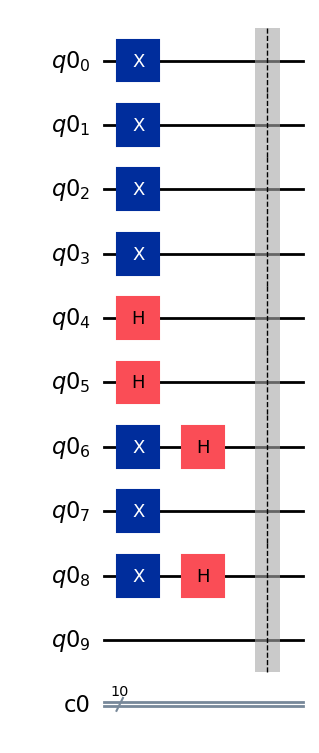

In [3]:
import random
from qiskit.circuit import QuantumRegister, ClassicalRegister

# アリス側の準備
alice_a = random.choices(('0', '1'), k=10)
alice_b = random.choices(('0', '1'), k=10)

# 作成したパラメータから量子状態の作成
qregs = QuantumRegister(10)
cregs = ClassicalRegister(10)
phi = QuantumCircuit(qregs, cregs) # まずは量子ビットの初期化

for i in range(len(alice_a)):
    if (alice_a[i] == '0') and (alice_b[i] == '1'):
        # Add H Gate
        phi.h(i)
    if (alice_a[i] == '1') and (alice_b[i] == '0'):
        # Add X Gate
        phi.x(i)
    if (alice_a[i] == '1') and (alice_b[i] == '1'):
        # Add X and H Gate
        phi.x(i)
        phi.h(i)

phi.barrier()
phi.draw('mpl')

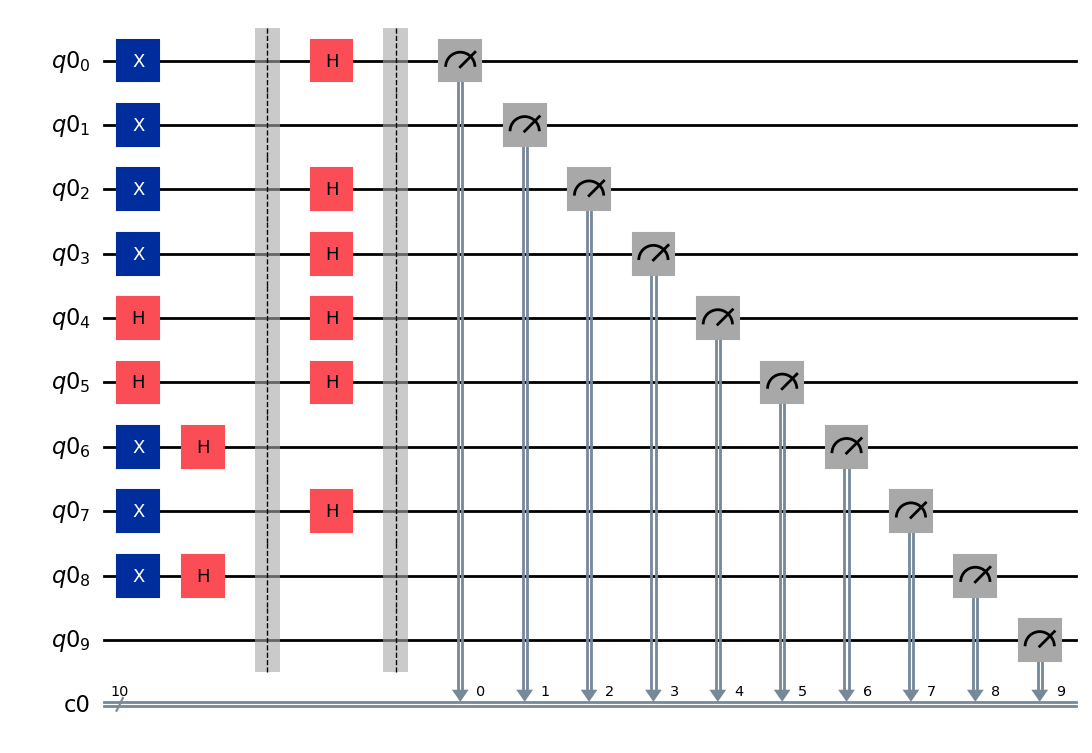

In [4]:
# ボブ側の準備
bob_b = random.choices(('0', '1'), k=10)

# 作成したパラメータに基づいて、基底を選択し、測定を行う。
for i in range(len(bob_b)):
    if bob_b[i] == '1':
        phi.h(i) # パラメータが「１」の場合、X基底での測定とするため、HゲートをかけてからZ基底測定する
        
phi.barrier()
phi.measure(qregs, cregs)
phi.draw('mpl')

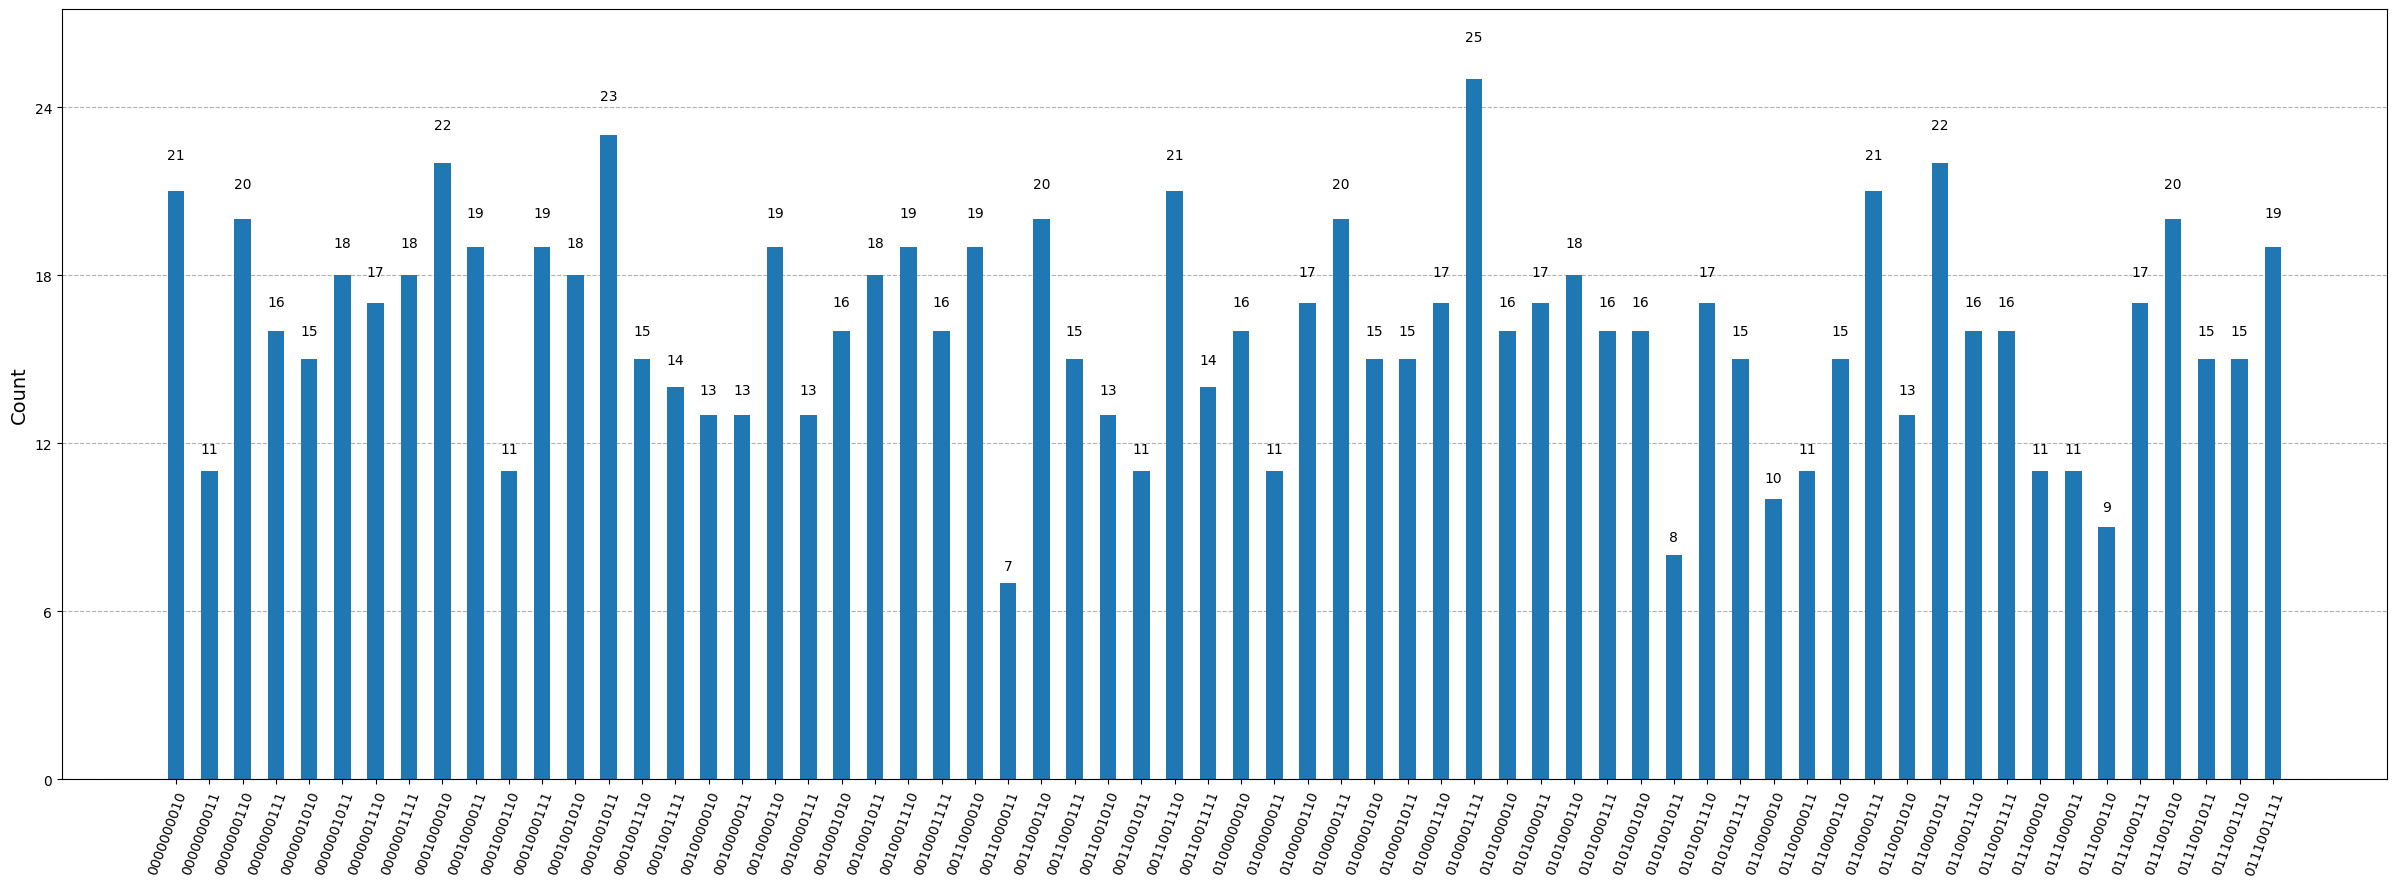

In [5]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
#from quri_parts.qiskit.backend import QiskitSamplingBackend

# Bobの測定まで量子回路に起こせたので、実際にシミュレーターで動かしてみる。
device = AerSimulator()
#backend = QiskitSamplingBackend(device)

#result = backend.sample(phi, n_shots=1).result()   quri-partsを使えば測定回数を制御できる。ただ、Pythonバージョンを落とす必要があったので一旦、断念。。
result = device.run(phi).result().get_counts()

plot_histogram(result, figsize=(30, 10))

In [6]:
#　ここで得られた結果は複数回測定されているので、測定結果としてランダムに選択する。
bob_c = list(reversed(random.choice(list(result.keys())))) # Qiskitの仕様で結果は右からインデックス「０」

alice_key = list()
bob_key = list()

# AliceとBobのパラメータの突き合わせ
for i in range(len(alice_b)):
    if alice_b[i] == bob_b[i]:
        alice_key.append(alice_a[i])
        bob_key.append(bob_c[i])

print("Alice パラメータa: ", alice_a)
print("Alice パラメータb: ", alice_b)
print("Bob パラメータb  : ", bob_b)
print("Bob 測定結果     : ", bob_c)
print("-----------------------------------")
print("Alice Key      : ", alice_key)
print("Bob Key        : ", bob_key)

Alice パラメータa:  ['1', '1', '1', '1', '0', '0', '1', '1', '1', '0']
Alice パラメータb:  ['0', '0', '0', '0', '1', '1', '1', '0', '1', '0']
Bob パラメータb  :  ['1', '0', '1', '1', '1', '1', '0', '1', '0', '0']
Bob 測定結果     :  ['0', '1', '1', '0', '0', '0', '1', '0', '0', '0']
-----------------------------------
Alice Key      :  ['1', '0', '0', '0']
Bob Key        :  ['1', '0', '0', '0']


と、アリスとボブで鍵を共有できることを確認できました。

>最初、鍵が一致せず。その原因の特定に時間かかりました。<br>
>Qiskitの測定結果は右からインデックス「0」となっているので、↑の実装では反転させないと行けなかった。<br>
>The string is little-endian (cr[0] on the right hand side).<br>
>https://docs.quantum.ibm.com/api/qiskit/qiskit.result.Result

### 4 Appendix：X基底での測定
BB64では、ランダムに作成したパラメータに応じて測定基底を選択することが、安全に鍵を共有するポイントになっている。
ただ、実際の測定自体はZ基底でしか測定できないため、X基底での測定は、測定対象の量子ビットにHゲートをかけてからZ基底で測定をすることで行う。

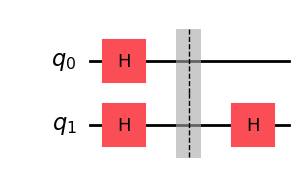

In [10]:
circ = QuantumCircuit(2)
circ.h(0)
circ.h(1)
circ.barrier()
circ.h(1)

circ.draw('mpl')

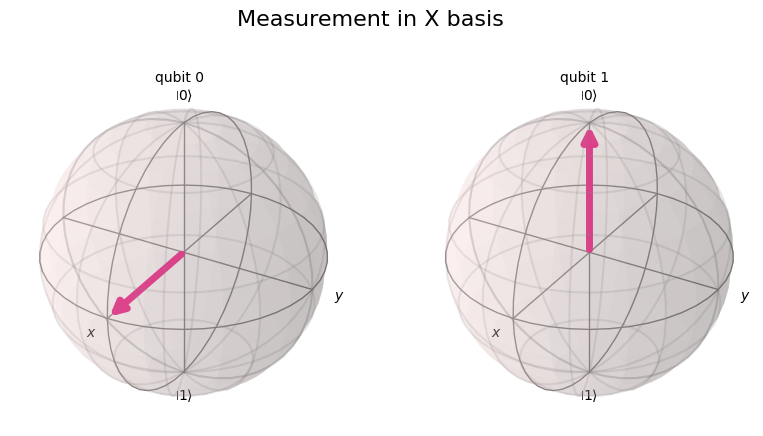

In [12]:
state = Statevector.from_instruction(circ)
plot_bloch_multivector(state, title="Measurement in X basis")

### 5 参考文献
- NTTジャーナル 「量子鍵配送について教えてください」
    - https://journal.ntt.co.jp/backnumber2/0608/files/jn200608049.pdf
- BB84をQiskitで実装してみた
    - https://qiita.com/Kumezawa/items/fde80e3c3a776817036f#alice%E3%81%A8bob%E3%81%A0%E3%81%91%E3%81%AE%E9%80%9A%E4%BF%A1
- 射影測定
    - https://sakumatcho.hatenablog.com/entry/2021/08/26/010200#%E8%A8%88%E7%AE%97%E5%9F%BA%E5%BA%95Computational-Basis
- Qiskit End-to-end examples
    - https://docs.quantum.ibm.com/migration-guides/qiskit-runtime-examples#use-estimator-to-design-an-algorithm